# Business and Data understanding

* Target of the "Quora Insincere Questions" -Competition is to build a binary text classification model
* CRISP-DM is selected as process model
* Basic assumption: Information contained in the trainset is sufficient to predict the target ( = column with question text)
* Aim of this Kernel is to get a basic understanding of the dataset (data exploration)

#### Import necessary libraries

In [1]:
# General
import os # to echo console messages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm # lib to show progress bar for certain funcions

# Visualization 
import seaborn as sns
import plotly.offline as py # plotly is a JaveScript based library to create visualizations
import plotly.graph_objs as go
from plotly import tools

# Data Exploration
import spacy # State-of-the-Art NLP library 
nlp = spacy.load('en_core_web_sm') # load english statistical model which was trained on web data((blogs, news, comments) more info: https://spacy.io/models#quickstart
from spacy.matcher import Matcher, PhraseMatcher # Rule based string matching

 ## Data exploration

In [2]:
# train dataset
pd.set_option('display.max_colwidth', 1500) # increase display column size
df = pd.read_csv("../input/train.csv")
print("Length Dataframe(Number of samples): ", df.shape)
df.head()

Length Dataframe(Number of samples):  (1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [3]:
# test dataset
df_test = pd.read_csv("../input/test.csv")
df_test['target'] = ""
df_test['question_text_length'] = df_test['question_text'].apply(len)
df_test2 = df_test[df_test.question_text_length < 70]
df_test2.head()

,qid,question_text,target,question_text_length
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitioner?,,50
3,000086e4b7e1c7146103,Who are entrepreneurs?,,22
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,,48
5,000101884c19f3515c1a,How do you train a pigeon to send messages?,,43
6,00010f62537781f44a47,What is the currency in Langkawi?,,33


#### Inspecting sincere questions

In [4]:
df[df.target == 0].sample(n=5) # sample 5 element random from dataframe

,qid,question_text,target
617745,78f9aedfaa43e6138cbc,What is like to become rich through a share sale of an Indian startup?,0
125535,1890611cb4154df79beb,How can I tell my sister to stop dating a close friend of mine without telling her the real reason? That friend of mine is extremely perverted and usually shows us everything private of his relationships like intimate pictures.?,0
224926,2bfc1012c74366e5d2c6,Who has been the biggest perpetrator of chemical weapons; aren't Agent Orange and napalm chemical weapons?,0
1059275,cf8dc4a2f5cb7b590051,Who is a god Hanuman sister?,0
896496,afa564aa33862d7085c7,How many days transit visa allow in Kuwait to visit city if I have USA visa?,0


#### Inspecting insincere questions

In [5]:
df[df.target == 1].sample(n=5) # sample 10 element random from dataframe

,qid,question_text,target
885751,ad8a1635733d8137addb,Why is the human skull flat?,1
642669,7de0b01a4d7fd8212d9d,Why do Muslim apologists keep telling us that Islam was not spread by the sword? But reality is something else.,1
316396,3e043222b31aad11bf08,Are Colombians sick of travelers going to Colombia and getting high on cocaine in the clubs and bars?,1
777348,9842ddba25af27b3a77c,Why do Americans lost their mind over the Bible? It´s just a story. What if in a thousand years they think Twighlight was a real thing?,1
1021526,c82f48b522f285196899,Do you think Guys who wear Pink shirts are Gay?,1


### Data Quality issues

* Samples derived from discussion: https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/71429#latest-459139

In [6]:
questions = df.loc[:, 'question_text']

#### a) Mislabeled Samples

* Samples which are definitely mislabeled.

In [7]:
from spacy.matcher import PhraseMatcher
toxic_matcher = PhraseMatcher(nlp.vocab)

# Add patterns to the matcher
phrase1 = nlp("Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?")
toxic_matcher.add('TOXIC_PATTERN', None, phrase1)
phrase2 = nlp("Have you licked the skin of a corpse?")
toxic_matcher.add('TOXIC_PATTERN', None, phrase2)
phrase3 = nlp("Why does America have to accept people from Sh1t hole countries?")
toxic_matcher.add('TOXIC_PATTERN', None, phrase3)
phrase4 = nlp("Why are Indian girls racist?")
toxic_matcher.add('TOXIC_PATTERN', None, phrase4)
phrase5 = nlp("Why do bitches kiss their teacher's ass?")
toxic_matcher.add('TOXIC_PATTERN', None, phrase5)
phrase6 = nlp("Why do womens enjoy being dominated during sex, even rough sex with ass slapping and hair pull but dislike rape?")
toxic_matcher.add('TOXIC_PATTERN', None, phrase6)
phrase7 = nlp("What does a cock taste like?")
toxic_matcher.add('TOXIC_PATTERN', None, phrase7)

mislabeled_samples = set()
for index, question in enumerate(questions):
    question = nlp.make_doc(question) # only use spacy tokenizer, improves speed
    matches = toxic_matcher(question)   
    # Iterate over the matches
    for match_id, start, end in matches:
        # Get the matched span
        matched_span = question[start:end]
        mislabeled_samples.add(index)
        
df.iloc[list(mislabeled_samples),[1,2]] # dont show column qid

,question_text,target
553858,Why does America have to accept people from Sh1t hole countries?,0
5,"Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?",0
618768,Why are Indian girls racist?,0
17,Have you licked the skin of a corpse?,0
1115506,What does a cock taste like?,0
1236863,"Why do womens enjoy being dominated during sex, even rough sex with ass slapping and hair pull but dislike rape?",0
702559,Why do bitches kiss their teacher's ass?,0


#### b) Ambiguous samples

* clearly labeled samples which humans would subjectivly would label different
* the intention of a question can not be identified clear-cut

In [8]:
from spacy.matcher import PhraseMatcher
amb_matcher = PhraseMatcher(nlp.vocab)

# Add the pattern to the matcher
phrase1 = nlp("Why did you vote for Donald Trump or Hillary Clinton?")
amb_matcher.add('TOXIC_PATTERN', None, phrase1)
phrase2 = nlp("Can bisexual people live their lives with either men or women only, or do they need both?")
amb_matcher.add('TOXIC_PATTERN', None, phrase2)
phrase3 = nlp("Why are so many evangelical Christians such staunch supporters of Donald Trump?")
amb_matcher.add('TOXIC_PATTERN', None, phrase3)

ambiguous_samples = set()
for index, question in enumerate(questions):
    question = nlp.make_doc(question) # only use spacy tokenizer, improves speed
    matches = amb_matcher(question)   
    # Iterate over the matches
    for match_id, start, end in matches:
        # Get the matched span
        matched_span = question[start:end]
        ambiguous_samples.add(index)
        
df.iloc[list(ambiguous_samples),[1,2]]

,question_text,target
105820,"Can bisexual people live their lives with either men or women only, or do they need both?",1
379687,Why did you vote for Donald Trump or Hillary Clinton?,0
177287,Why are so many evangelical Christians such staunch supporters of Donald Trump?,1


#### c) Noise samples

* samples are not toxic but should be labeled as insincere because they represent spam

In [9]:
from spacy.matcher import PhraseMatcher
noise_matcher = PhraseMatcher(nlp.vocab)

# Add the pattern to the matcher
phrase1 = nlp("How can I?")
noise_matcher.add('TOXIC_PATTERN', None, phrase1)
phrase2 = nlp("Am I fake?")
noise_matcher.add('TOXIC_PATTERN', None, phrase2)

noise_samples = set()
for index, question in enumerate(questions):
    question = nlp.make_doc(question) # only use spacy tokenizer, improves speed
    matches = noise_matcher(question)   
    # Iterate over the matches
    for match_id, start, end in matches:
        # Get the matched span
        matched_span = question[start:end]
        noise_samples.add(index)
        
df.iloc[list(noise_samples),[1,2]]

,question_text,target
747170,I want to become an Android developer. How can I?,0
628126,"I created a WhatsApp group, I exited from that. I want to delete that group. How can I?",0
205479,"I want to become a neuroscientist, neurologist & neurosurgeon. How can I?",0
573447,How can I become a C1 ventilator quadriplegic like Christopher Reeve? This is my dream. How can I?,1
658824,I want to be a mermaid. How can I?,0
685002,I love programming and I want to become a billionaire. How can I?,0
1096967,I wanna fuck you.How can I?,1
370252,I want to kill myself but I want to stop myself. How can I?,0
378765,Am I fake?,0
779950,"Why is it so hard to ask my friends for help? I was planning to commit suicide in a few days, and I wanted to open up to them about my plans, but I dont want to burden them. I am so scared. How can I?",0


e.g. "How can I? and "Am I Fake" are spam questions compared to other sincere questions using this expressions

#### d) Spelling mistakes samples

* samples intentional/unintended spelled wrong. This makes it difficult for a model to identify toxic phrases especially if there masked words such as f*** or st*up*id
* some samples taken from: https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2

In [10]:
from spacy.matcher import PhraseMatcher
spell_matcher = PhraseMatcher(nlp.vocab)

# example intentional masked toxic tokens
terms = ['pennis','s***','f***','p*rn','d***','b*tch', 'b***', 'mastrubation']
# run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in terms]
spell_matcher.add("MaskedWords", None, *patterns)

spell_error_samples = [] # set that matched questions only appear once in output
for index, question in enumerate(questions):
    question = nlp.make_doc(question) # only use spacy tokenizer, improves speed
    matches = spell_matcher(question)   
    # Iterate over the matches
    for match_id, start, end in matches:
        # Get the matched span
        matched_span = question[start:end]
        spell_error_samples.append(index)

print("Number of masked toxic tokenssaples: ", len(spell_error_samples))
df.iloc[list(spell_error_samples),[1,2]].head()

Number of masked toxic tokenssaples:  56


,question_text,target
72325,"Isn't the whole ""e-sports"" thing a bunch of pretentious white guy b*ll-s***?",1
84407,How? To clean inside the pennis,0
98366,What are the some unusual methods of mastrubation seen in malesl?,0
133592,Why is Sarah Huckabee Sanders such a b****?,1
194290,What should do to increase the pennis?,0


**Conclusion**

* "Rubbish in, rubbish out" -  model accuracy highly depends on the data quality of the training dataset
*  Does it make sense to correct labels? 
    * general: each correction/preprocessing step should be applied to the test set as well. Train and Test set should have a similar  
         distribution of samples  
    * Manual correction of certain samples is not feasible (Workload to high). 
    * Quora instead should conduct an error analysis why such a massive amount of data was mislabeled.
    * Priority should be given samples that are definitely toxic but were not respectively labeled.
        * bad human annotators?
        * weak ML-based anotation algorithms? - further research needed in this direction
    * Mislabed samples → Keyword based correction mechanism is quite dangerous. Risk of discrimination!
    * Ambiguous samples → Model can not outperform human annotators and just reproduces their reality /annotation scheme.
    * Noisy samples → should not be excluded from the training dataset because model should learn to handle noise. However, in the future it 
      would make sense to improve labeling scheme (label noise as insincere). This would enable a model to detect noise and reduce spam on 
      Quora.com
    * Spelling mistakes → A huge problem with active research especially towards handling word obfuscation. Char n-grams help.   

### Inspecting class distribution

In [11]:
cnt_target = df['target'].value_counts() # count total number of entries

targets = np.array(cnt_target.index) # derive both indices 0 and 1
class_descriptions = (' sincere', ' insincere')
labels = np.array(tuple(zip(targets, class_descriptions))) # add descfnlpription to labels
values = (np.array((cnt_target / cnt_target.sum())*100)) # derive class percentage of total

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=['#31B404', '#FF0000'], line=dict(color='#000000', width=2)))
fig.show()

- Attention: Training dataset is a highly imbalanced dataset!
- Consequences: Metric Accuracy is not a suitable metric to assess model performance.<br />            If Insincere Questions (class 1) are defined as the positive class then special attention has to be paid on False Negatives in a Confusion Matrix (comp. figure 14). This would mean that the model was not able to identify the toxic question.

### Exploring TOP 20 Unigrams and Bigrams

- Are there any words/expressions that could be responsible for the insincere labeling of a question?

In [12]:
# Code sligthly adapted from: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

from collections import defaultdict
from wordcloud import STOPWORDS

train1_df = df[df["target"]==1]
train0_df = df[df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="TOP 20 Word Count Plots (Training dataset)")
py.iplot(fig, filename='word-plots')

/opt/conda/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



With focus on the insincere section:
- certain groups apparently are more likely victim of attacks (blacks, muslims, indians)
- some words indicate discriminiation such as "black" and "white"
- the word "sex" is also contained in the TOP 20 which is consistent with the labeling of criteria of a insincere question: <br />  ("Uses sexual content [...] not to seek genuine answers")

Attention: <br />
- Special focus should be taken on what the later model really learns. A popular problem is that a model misleadlingly learns something like black=insincere or "white"=sincere. This would mean the model itself behaves racist or discriminatory adverse certain groups. 

In [13]:
# Code sligthly adapted from: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="TOP 20 Bigram Count Plots")
py.iplot(fig, filename='word-plots')

- The Topic "Donald Trump" apparently carries potential for conflicts on Quora

#### Statistical features ? 

- Are there any statistical features that could be used as model input? 
- Does maybe the length of a questions or its number of words indicate whether it is insincere or not?
- Apply Named Entity recognition e.g. for "Donald Trump" 

In [14]:
df['question_text_length'] = df['question_text'].apply(len)
df3 = df[df.question_text_length < 70]

In [15]:
df3[df3.target == 0].sample(n=5) # sample 10 element random from dataframe

,qid,question_text,target,question_text_length
1220654,ef3dd341c17cf60fe149,What defines the acting style of Mariah Carey?,0,46
776235,980c0a320eacf7347709,What is the worst Batman comic?,0,31
993969,c2c95f1797fe3e335bc0,Which one is the best-in-time LG AC service centre in Hyderabad?,0,64
112549,1604fe220feb1e6c726a,What is the expected cutoff for neet 2017 for MP state?,0,55
697979,88ad9367898c29e102db,How do you wear westen boots?,0,29


In [16]:
df3[df3.target == 1].sample(n=5) # sample 10 element random from dataframe

,qid,question_text,target,question_text_length
573064,704a63c3dfe86ef70e7c,"Are New Zealand, Australia and Canada really countries?",1,55
1099198,d76c2a86b074c3ac2ed6,How do you defeat feminism in the western world?,1,48
567538,6f33a241e751984915c1,Why do nihilists fear their own personality?,1,44
1140305,df74c0bcbddf96b82689,Why are there corners everywhere if the Earth is round?,1,55
825845,a1d7ef7bc0df7f8f095d,Why do Greeks and Spaniards take so many siestas every day?,1,59


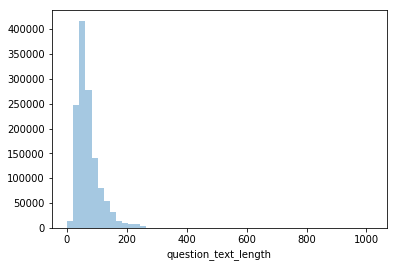

In [17]:
sns.distplot(df['question_text_length'],kde = False)
plt.show()

* Create Statistical features for each question

- number of characters
- number of words
- number of punctuation marks
- number of stopwords 

In [18]:
# df2 = df.loc[:50000, :]
df2 = df

In [19]:
questions = nlp.pipe(df2.loc[:,'question_text'], n_threads = 2) # Takes a stream of documents, yielding them in turn.

list_cnt_stop = []
list_cnt_alpha = []
list_cnt_punct = []
# list_cnt_shape = [] 
list_cnt_num = []
list_cnt_not_ascii = []

os.system('echo Starting spacy procedure')
for question in tqdm(questions):
    cnt_stop = 0 # counter stopwords
    cnt_alpha = 0 # how man words only contain alphanumerical characters
    cnt_punct = 0 # count punctuation
    # cnt_shape = 0  # counter shape: the word shape – capitalization, punctuation, digits.
    cnt_num = 0 # Does the token represent a number? e.g. “10.9”, “10”, “ten”, etc.
    cnt_not_ascii = 0 # Does the token NOT consist of ASCII characters? - e.g. asian characters
    
    for token in question:
        if token.is_stop:
            cnt_stop += 1
        if token.is_punct:
            cnt_punct +=1
        if token.is_alpha:
            cnt_alpha +=1
        if token.like_num:
            cnt_num +=1
        if not token.is_ascii:
            cnt_not_ascii  +=1
            
    list_cnt_stop.append(cnt_stop)
    list_cnt_punct.append(cnt_punct)
    list_cnt_alpha.append(cnt_alpha)
    list_cnt_num.append(cnt_num )
    list_cnt_not_ascii.append(cnt_not_ascii)
    
df2.loc[:, 'cnt_stop'] = list_cnt_stop
df2.loc[:,'cnt_punct'] = list_cnt_punct
df2.loc[:,'cnt_alpha'] = list_cnt_alpha
df2.loc[:,'cnt_num'] = list_cnt_num
df2.loc[:,'cnt_not_ascii'] = list_cnt_not_ascii

df2.head()

,qid,question_text,target,question_text_length,cnt_stop,cnt_punct,cnt_alpha,cnt_num,cnt_not_ascii
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,72,8,1,12,0,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,81,10,2,16,0,0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,67,3,2,10,0,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,57,4,1,9,0,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,77,7,1,15,0,0


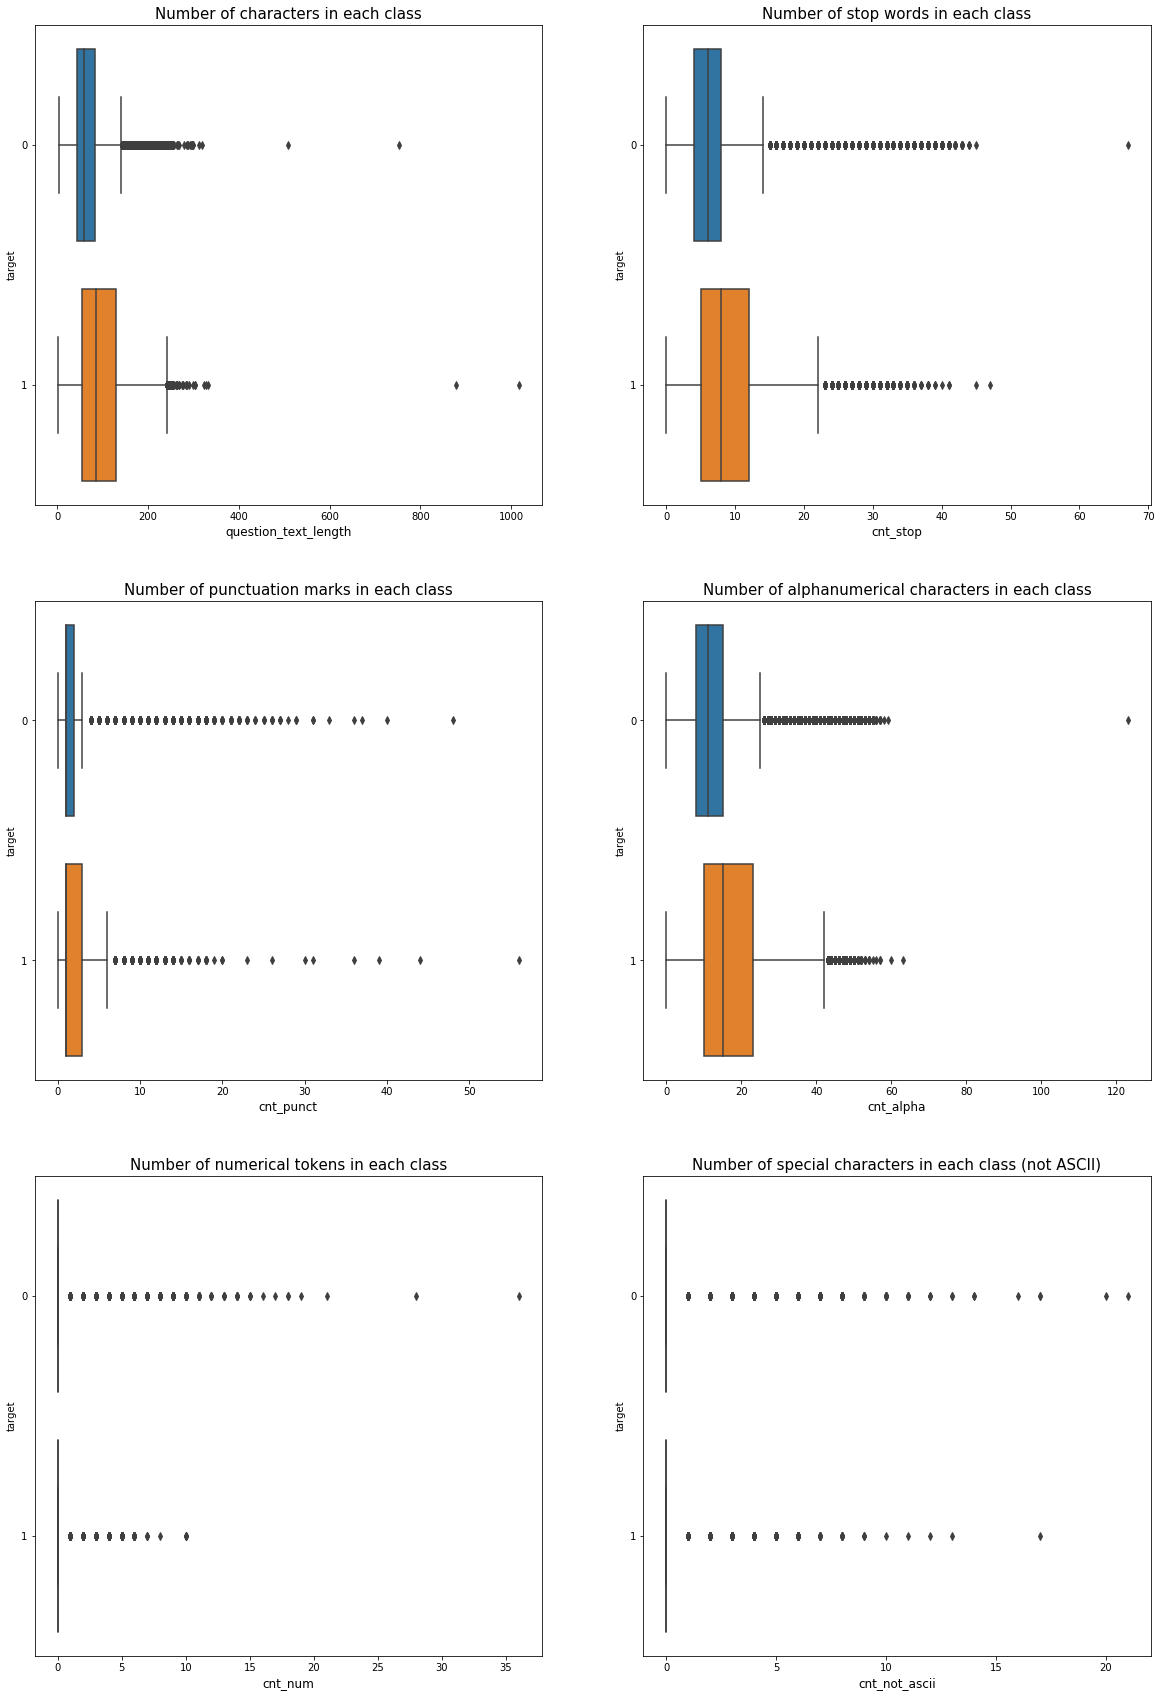

In [20]:
f = plt.figure(figsize=(20,30))

ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)

sns.boxplot(y='target',x ='question_text_length', data=df2, ax=ax1, orient = 'h')
ax1.set_xlabel('question_text_length', fontsize=12)
ax1.set_title("Number of characters in each class", fontsize=15)

sns.boxplot(y='target', x='cnt_stop', data=df2, ax=ax2, orient = 'h')
ax2.set_xlabel('cnt_stop', fontsize=12)
ax2.set_title("Number of stop words in each class", fontsize=15)

sns.boxplot(y='target', x='cnt_punct', data=df2, ax=ax3, orient = 'h')
ax3.set_xlabel('cnt_punct', fontsize=12)
ax3.set_title("Number of punctuation marks in each class", fontsize=15)

sns.boxplot(y='target',x ='cnt_alpha', data=df2, ax=ax4, orient = 'h')
ax4.set_xlabel('cnt_alpha', fontsize=12)
ax4.set_title("Number of alphanumerical characters in each class", fontsize=15)

sns.boxplot(y='target', x='cnt_num', data=df2, ax=ax5, orient = 'h')
ax5.set_xlabel('cnt_num', fontsize=12)
ax5.set_title("Number of numerical tokens in each class", fontsize=15)

sns.boxplot(y='target', x='cnt_not_ascii', data=df2, ax=ax6, orient = 'h')
ax6.set_xlabel('cnt_not_ascii', fontsize=12)
ax6.set_title("Number of special characters in each class (not ASCII)", fontsize=15)

plt.show()

- insincere questions tend to be longer (more characters)